In [47]:
import torch 
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [48]:
data = pd.read_excel("film.xlsx")
data

,序号,电影名称,主演1,主演2,导演,想看人数,评分,发行公司,制作技术,档期,IP,首周票房,电影类型,百度搜索指数,票房
0,1,流浪地球,339,1391,1,506106,7.9,1,1,1,1,202117,科幻、剧情,81665,46.18
1,2,我和我的祖国,4261,874,9,99463,7.8,1,1,1,0,205195,剧情,375780,31.46
2,3,中国机长,150,1095,26,71001,6.7,1,1,1,1,174588,剧情、灾难,87639,28.84
3,4,疯狂的外星人,4261,1171,14,558595,6.4,1,1,1,1,145607,喜剧、科幻,41007,21.83
4,5,飞驰人生,1171,1258,0,325411,6.9,0,1,1,0,104832,喜剧,30487,17.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,198,万物生长,6291,5386,7,11830,5.7,0,1,0,1,7280,爱情、剧情,41900,1.48
198,199,破风,3288,1453,10,14931,7.3,0,1,1,0,7019,剧情,44758,1.45
199,200,王朝的女人·杨贵妃,6291,119,0,4552,3.7,1,1,1,1,9247,爱情、古装,10246,1.34
200,201,爸爸的假期,1145,7365,0,1931,4.0,1,0,1,1,5703,喜剧,21769,1.12


如RMSE和MAE还是有问题的，是因为量纲不一样。比如我们预测考试分数误差是10，预测房价误差是1w。但我们却不能评价我们的模型是更适合预测分数还是预测房价,

R2<=1，R2越大预测模型越好，最大值为1，当R2为0时预测模型等于基准模型，当R2<0时说明预测模型还不如基准模型，也可能数据不存在线性关系。

## 数据预处理

### 1.缺失值查看

In [49]:
null_data = data.isnull().sum().sort_values(ascending=False)
missing_data = pd.DataFrame({"缺失值占比":null_data})
missing_data

,缺失值占比
序号,0
电影名称,0
主演1,0
主演2,0
导演,0
想看人数,0
评分,0
发行公司,0
制作技术,0
档期,0


### 2.查看票房的基本信息

count    202.000000
mean       6.534257
std        8.126373
min        1.000000
25%        1.815000
50%        3.570000
75%        7.460000
max       56.390000
Name: 票房, dtype: float64
-----------------------------
偏度：2.9853305585015026
峰值：11.143613277097733


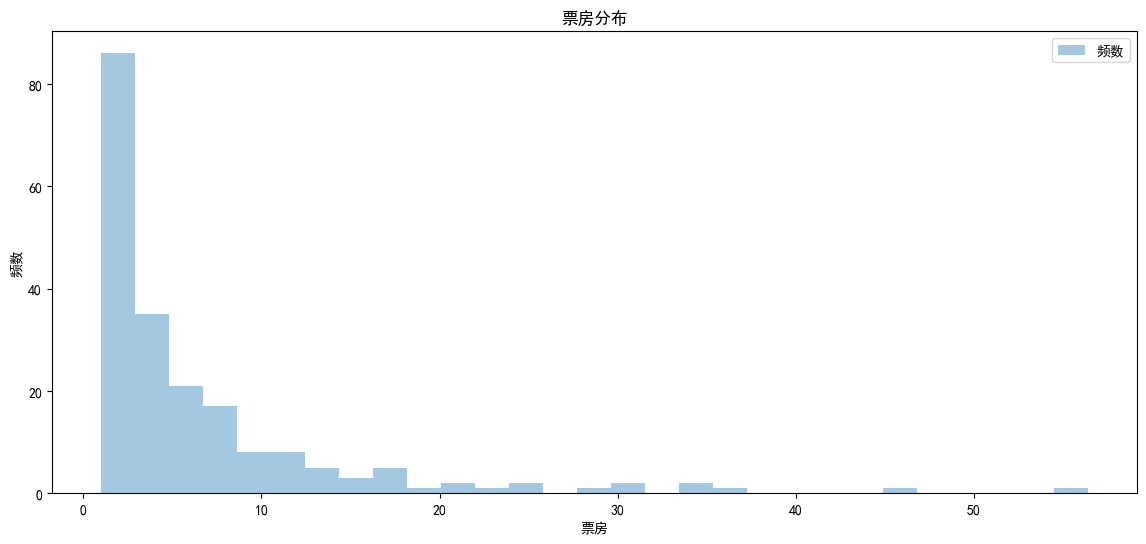

In [50]:
print(data['票房'].describe())#统计一下房价的基本信息
print('-----------------------------')
print('偏度：{}'.format(data['票房'].skew()))
print('峰值：{}'.format(data['票房'].kurt()))
plt.figure(figsize=(14,6))
plt.title('票房分布')
plt.ylabel('频数')
sns.distplot(data['票房'],kde = False,hist_kws = {'label':'频数'})
plt.legend()#显式图例

### 3.查看分类变量的数据分布

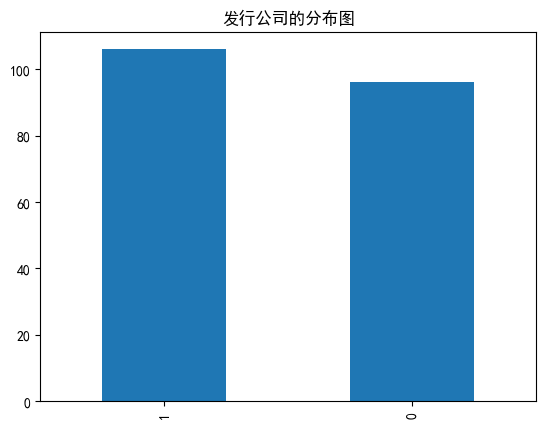

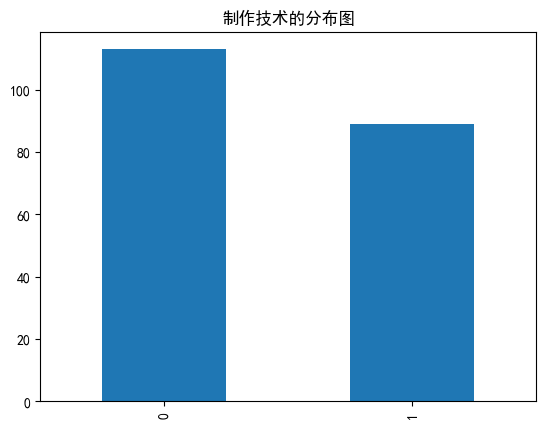

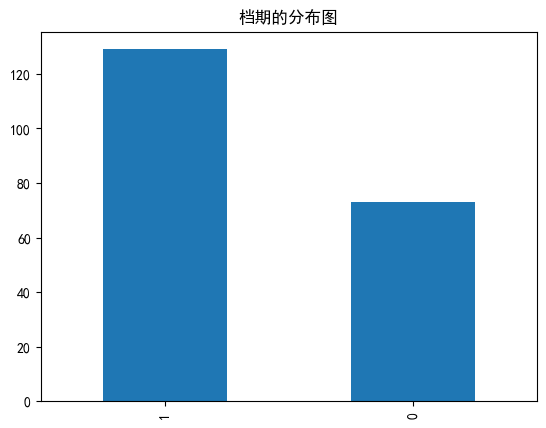

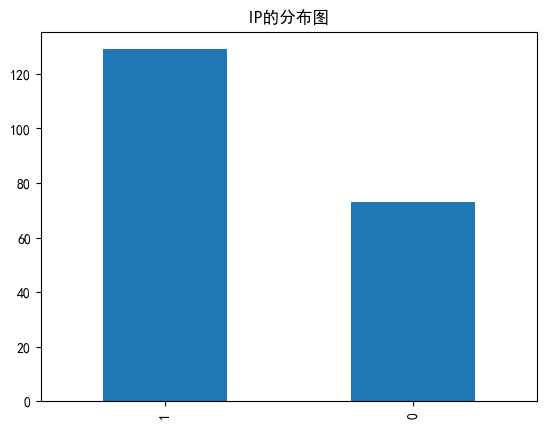

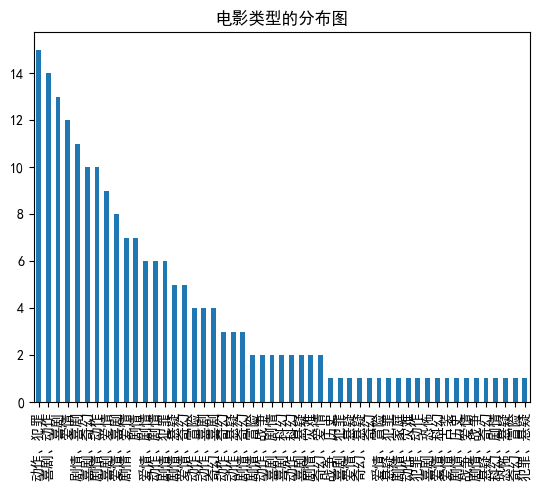

In [51]:
# 个分类变量的数量占比

cat_cols = ["发行公司","制作技术","档期","IP","电影类型"]
for i in cat_cols:
    data[i].value_counts().plot(kind='bar')
    plt.title(f"{i}的分布图")
    plt.show()

### 4.数值型数据的处理与查看

<Figure size 10800x3600 with 0 Axes>

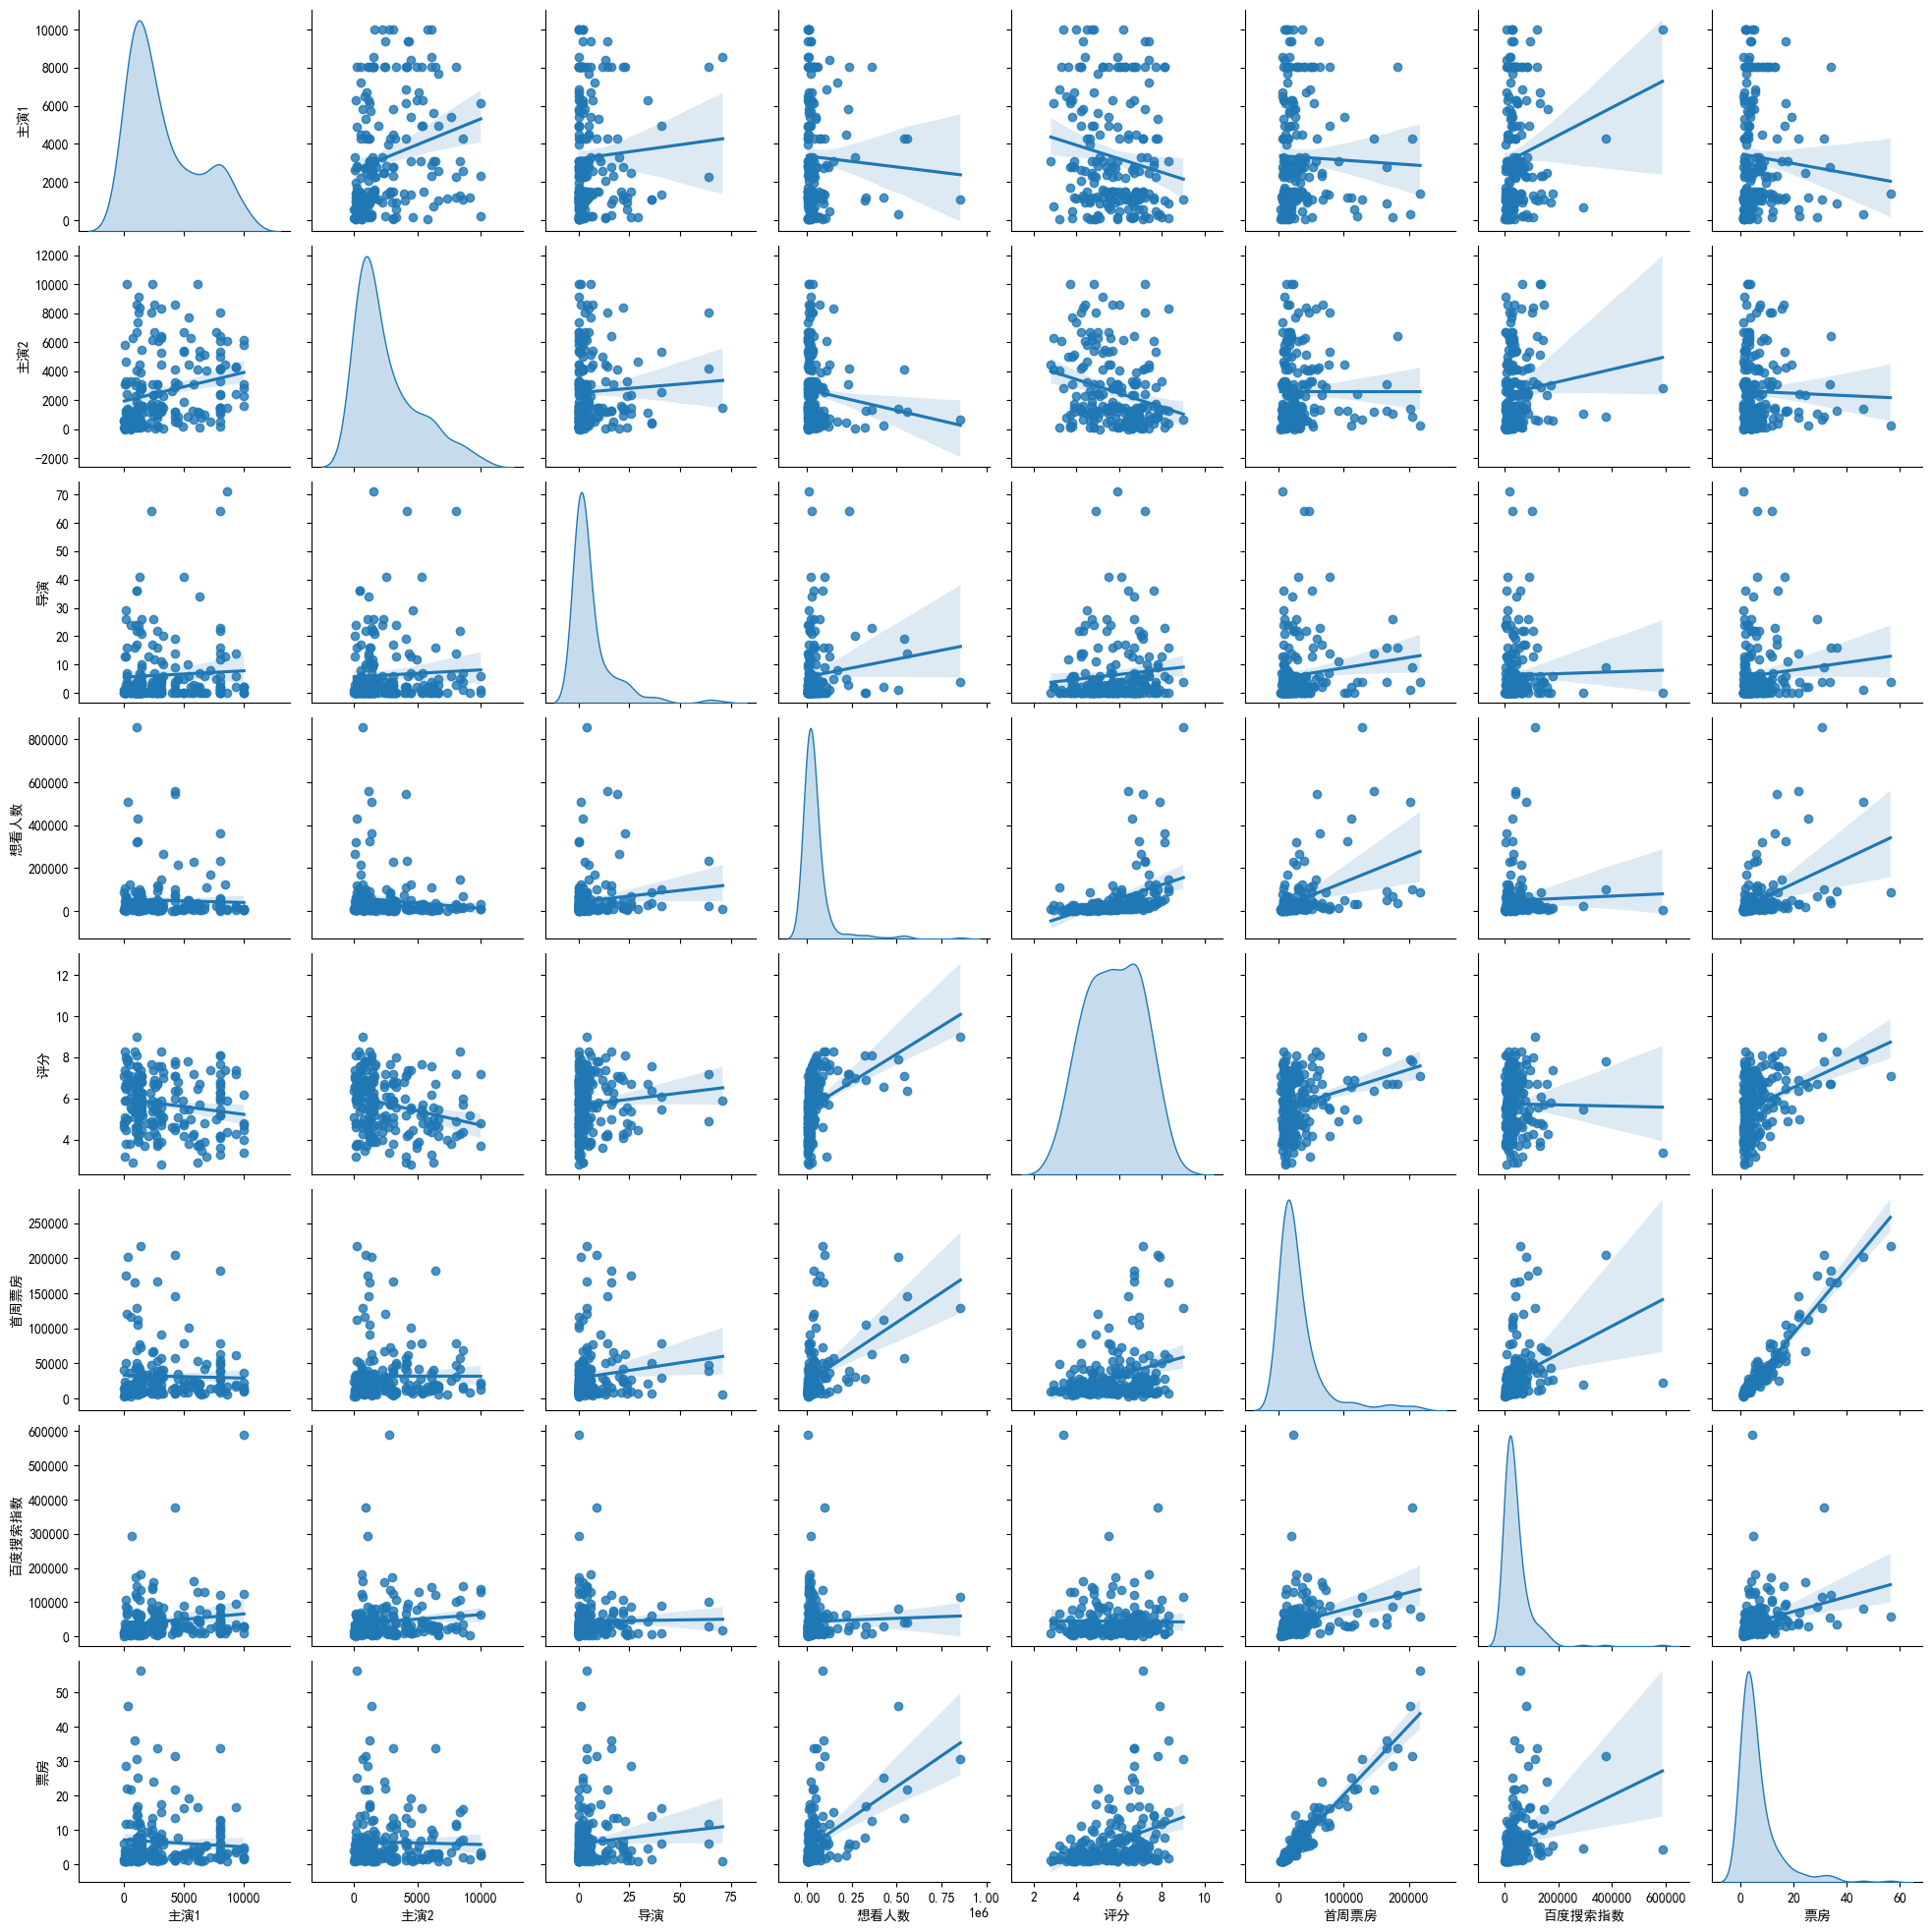

In [91]:
# 查看变量之间的相关性
num_cols = ["主演1","主演2","导演","想看人数","评分","首周票房","百度搜索指数","票房"]
plt.figure(figsize=(18,6),dpi=600)
sns.pairplot(data[num_cols],  kind="reg", diag_kind = 'kde')

<AxesSubplot:xlabel='首周票房', ylabel='票房'>

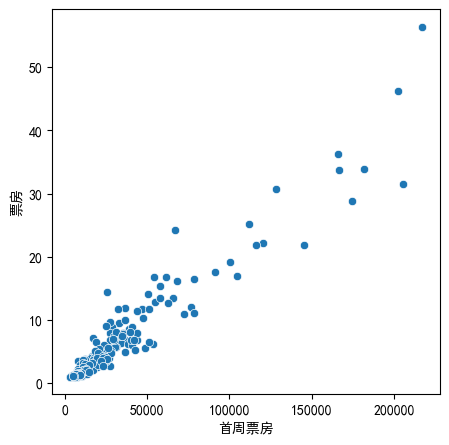

In [53]:
# 在图中，似乎看到了首周票房与票房之间存在着较强的线性惯性，仔细再来看看
plt.figure(figsize=(5, 5))
sns.scatterplot(x=data['首周票房'],y= data['票房'])


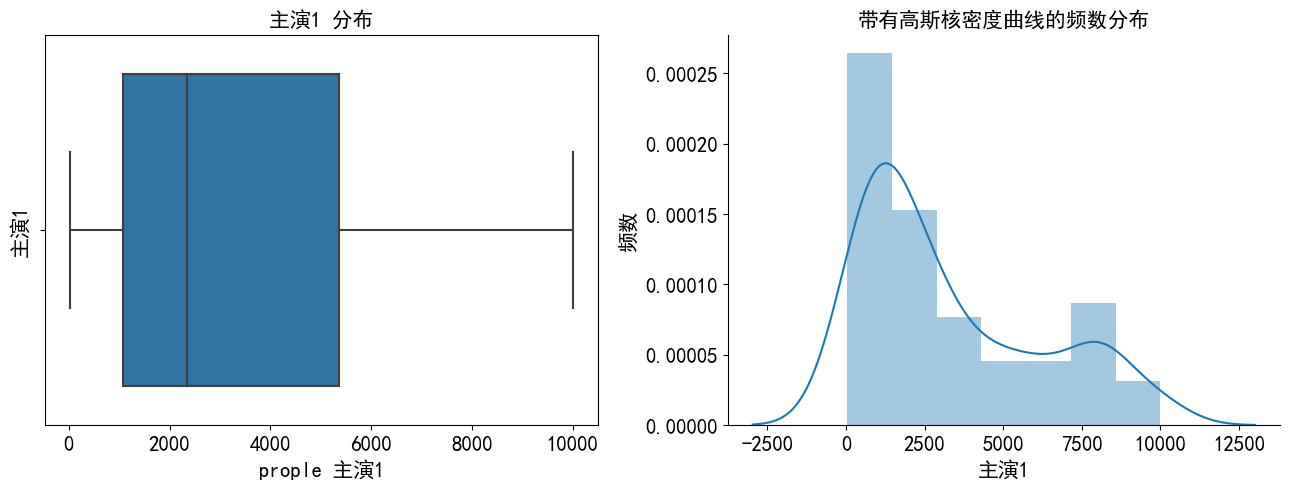

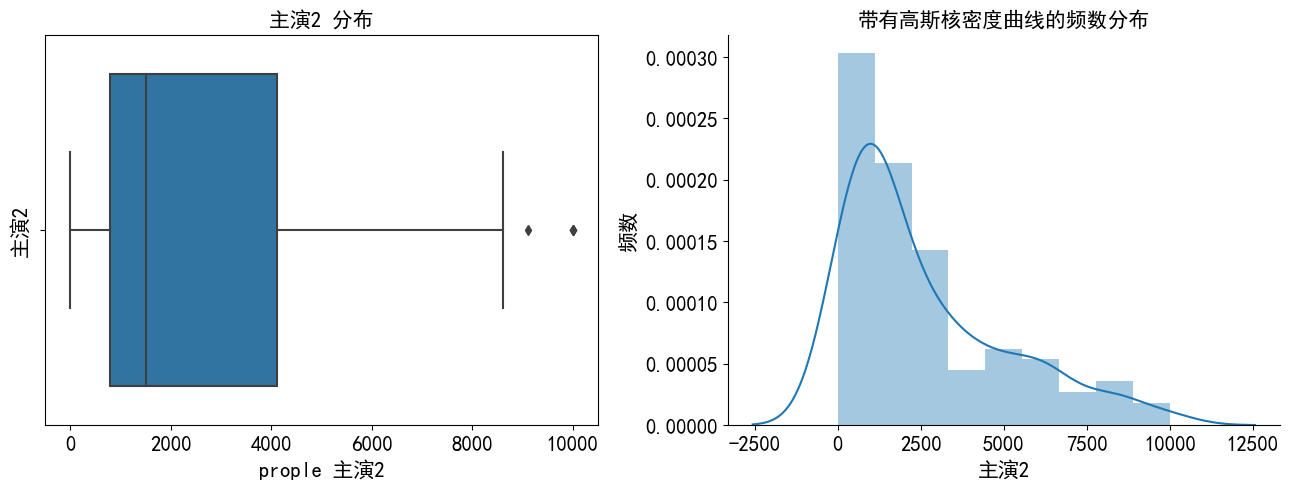

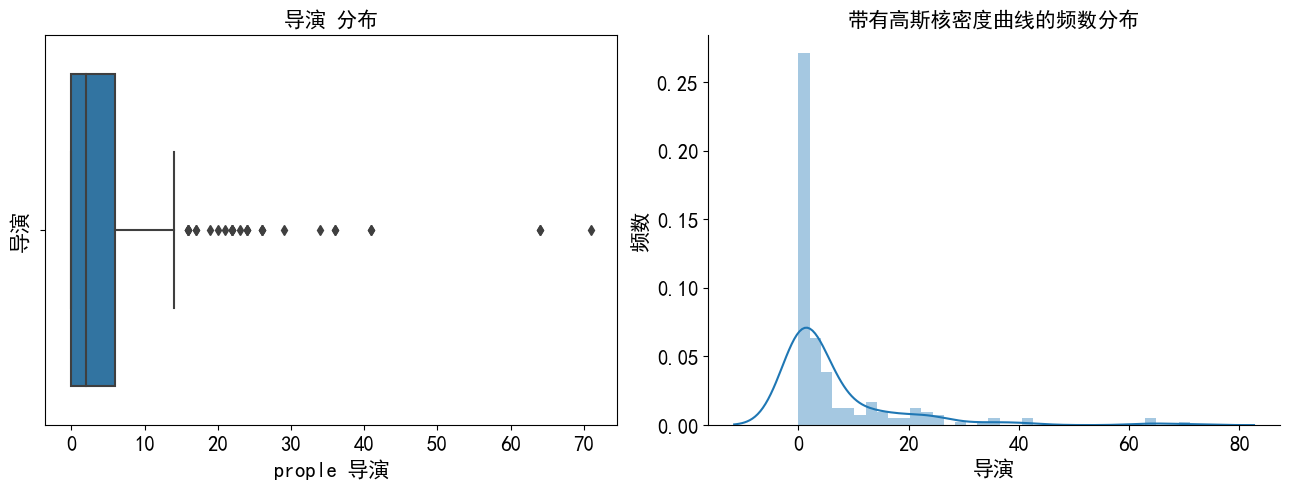

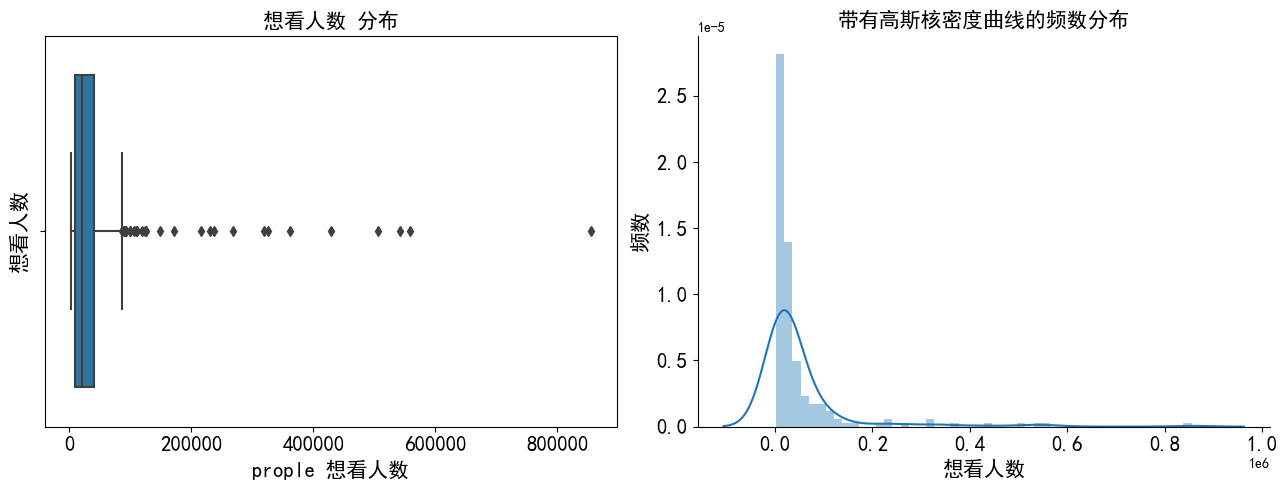

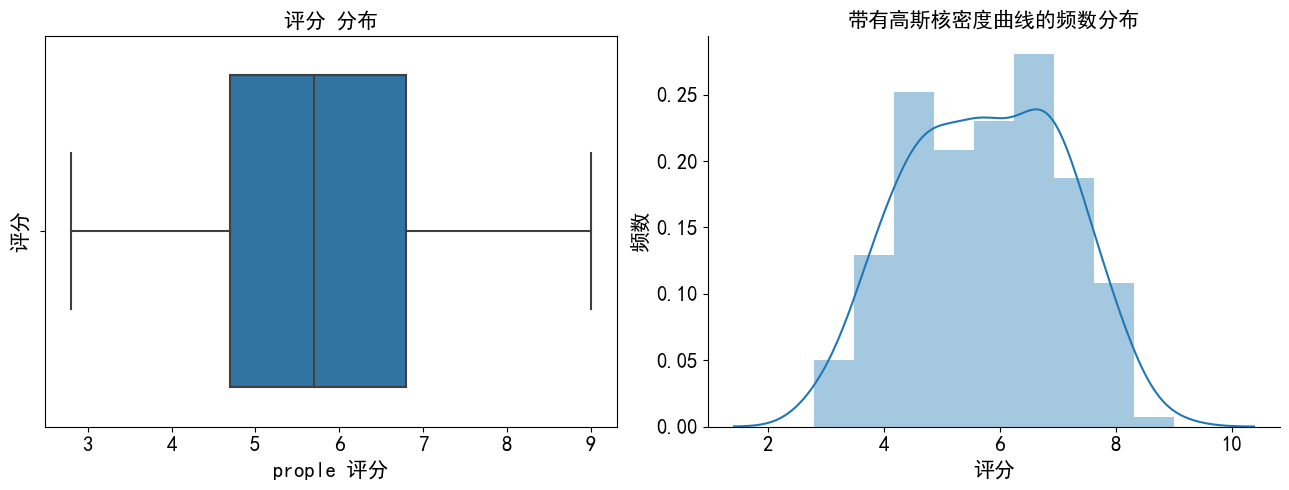

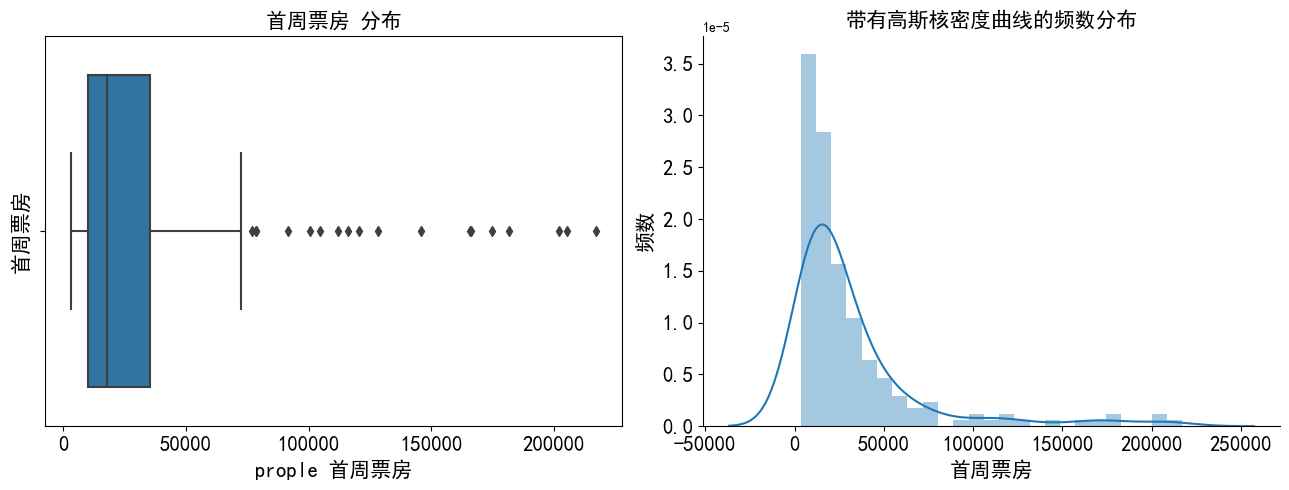

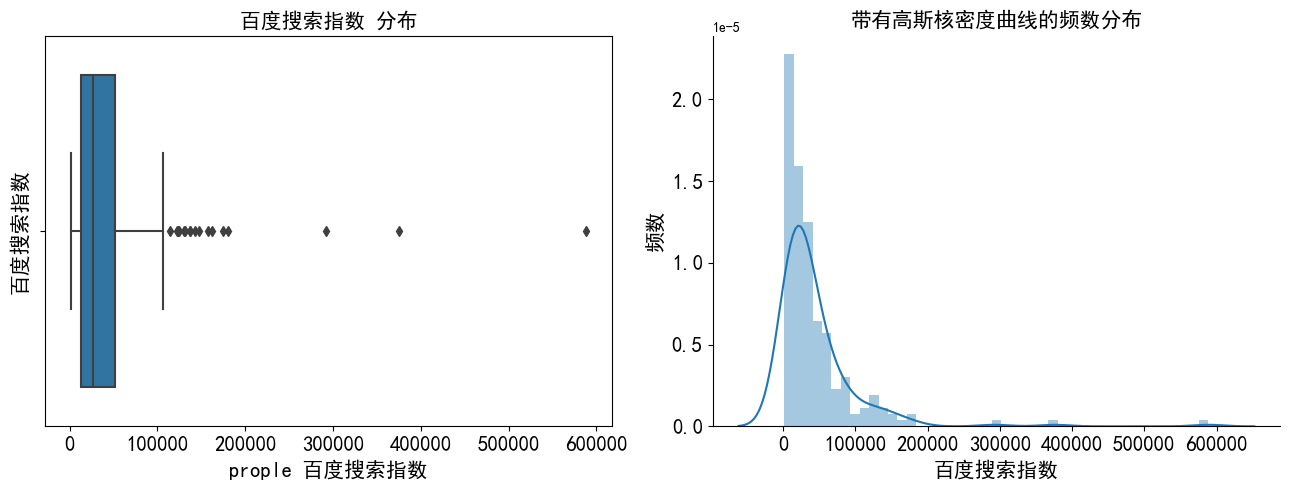

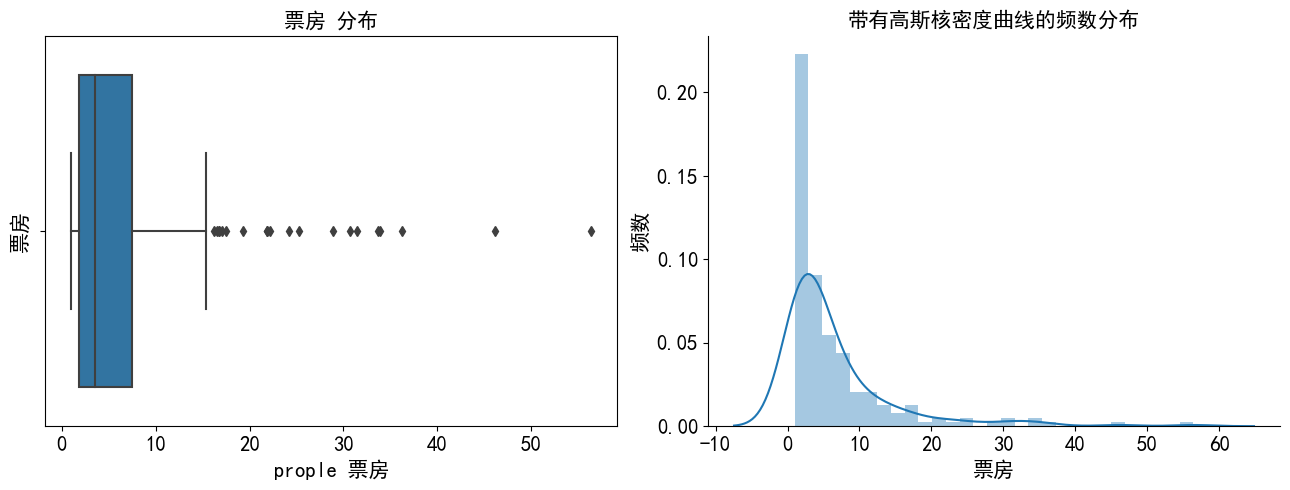

In [54]:
# 看一下数据的分布以及离群点
def show_info():
    for i in num_cols:
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
        sns.boxplot(x = i, data = data, orient = 'v', ax = ax1)
        ax1.set_xlabel(f"prople {i}", fontsize=15)
        ax1.set_ylabel(i, fontsize=15)
        ax1.set_title(f'{i} 分布', fontsize=15)
        ax1.tick_params(labelsize=15)

        sns.distplot(data[i], ax = ax2)
        sns.despine(ax = ax2)
        ax2.set_xlabel(i, fontsize=15)
        ax2.set_ylabel('频数', fontsize=15)
        ax2.set_title('带有高斯核密度曲线的频数分布', fontsize=15)
        ax2.tick_params(labelsize=15)

        plt.subplots_adjust(wspace=0.5)
        plt.tight_layout() 
show_info()

从这里也可以看出存在了大量的异常点，因此在下面直接采用RobustScaler放缩来处理数据，剔除掉异常值会使模型精度提升。

在进行小批量随即下降的时候，四分位放缩的效果却不如直接进行标准化。

In [55]:
_data = data[num_cols]

<AxesSubplot:>

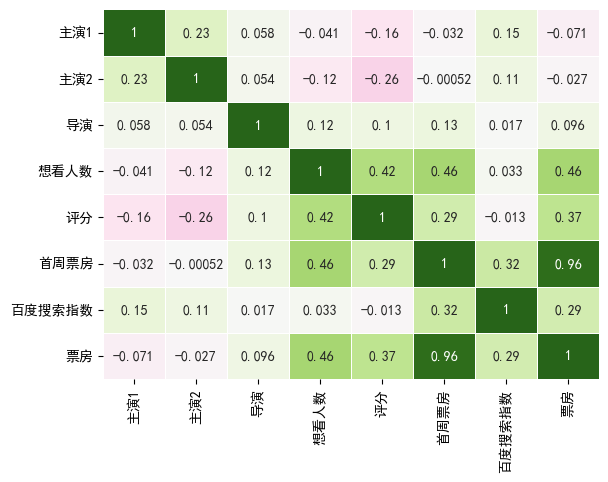

In [56]:
# sns.set(rc={'figure.figsize':(12,6)})
sns.heatmap(_data.corr(),
          annot=True,
          linewidths=.4,
          center=0,
          cbar=False,
          cmap="PiYG")

## 一元线性回归

模型:

$$y = \theta x$$

损失函数:

这里计算的所有数据的误差。并且再这里我们就除以了整个样本。为什么是2m？为了求导好求？

$$J = \frac{1}{2\times m} \sum_{i=1}^m (\hat y- y )^2$$

梯度下降：

在这里对损失函数求导可得(这里只有一个参数，直接对w进行求导)

$$
\begin{aligned} 

J = \frac{1}{2\times m} \sum_{i=1}^m (\hat y- y )^2 =\frac{1}{2\times m} \sum_{i=1}^m (xw- y )^2\\

\frac{\partial J}{\partial w} = 2 \times \frac{1}{2m} \sum_{i=1}^m (xw-y)x = \frac{1}{m} \sum_{i=1}^m (\hat y-y)x

\end{aligned}


$$



评估：
$$ R^2 = 1-\frac{\sum_{i=1}^m(\hat y_i - y_i)^2}{\sum_{i=1}^m( y_i - \overline y)^2}$$

$$MSE = \frac{1}{m} \sum_{i=1}^m(\hat y_i - y_i)^2$$

### 1.定义模型、损失函数、梯度下降

In [57]:
data

,序号,电影名称,主演1,主演2,导演,想看人数,评分,发行公司,制作技术,档期,IP,首周票房,电影类型,百度搜索指数,票房
0,1,流浪地球,339,1391,1,506106,7.9,1,1,1,1,202117,科幻、剧情,81665,46.18
1,2,我和我的祖国,4261,874,9,99463,7.8,1,1,1,0,205195,剧情,375780,31.46
2,3,中国机长,150,1095,26,71001,6.7,1,1,1,1,174588,剧情、灾难,87639,28.84
3,4,疯狂的外星人,4261,1171,14,558595,6.4,1,1,1,1,145607,喜剧、科幻,41007,21.83
4,5,飞驰人生,1171,1258,0,325411,6.9,0,1,1,0,104832,喜剧,30487,17.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,198,万物生长,6291,5386,7,11830,5.7,0,1,0,1,7280,爱情、剧情,41900,1.48
198,199,破风,3288,1453,10,14931,7.3,0,1,1,0,7019,剧情,44758,1.45
199,200,王朝的女人·杨贵妃,6291,119,0,4552,3.7,1,1,1,1,9247,爱情、古装,10246,1.34
200,201,爸爸的假期,1145,7365,0,1931,4.0,1,0,1,1,5703,喜剧,21769,1.12


In [58]:
def model(x, theta):
    h = x.dot(theta)  # 预估值h
    return h

def loss(h, y):
    m = len(h)  # 计算样本数
    e = h - y  # 误差
    J = 1.0 / (2 * m) * np.sum(e.T.dot(e))  # 计算代价
    return J


# alpha=0.001学习率
# count_iter=15000迭代次数
def gradDesc(x, y, alpha=0.01, count_iter=100):
    m, n = x.shape  # sharp返回值是元组（行，列）并赋值给m,n
    theta = np.zeros((n, 1))  # 定义theta初始值,theta为矩阵（从初始值开始，沿着初始值下降）
    jarr = np.zeros(
        count_iter
    )  # 代价数组(多维数组<class 'numpy.ndarray'>)[0. 0. 0. ... 0. 0. 0.]
    # 对theta进行更新
    for i in range(count_iter):
        h = model(x, theta)  # 计算预估值
        jarr[i] = loss(h, y)  # 计算代价并存入数组
        e = h - y  # 计算误差
        deltatheta = (1.0 / m) * x.T.dot(e)  # 计算deltatheta（梯度下降）,在这里x.T.dot(e)上面的公式求和右边的部分
        theta -= alpha * deltatheta  # 更新deltatheta（迭代）

    return jarr, theta

### 2.数据处理

In [59]:
x_train = np.array([data['首周票房'].values]).reshape(-1,1)
y_train= np.array([data['票房'].values]).reshape(-1,1)

# 数据标准化处理
from sklearn.preprocessing import RobustScaler      # 四分位放缩，解决异常值问题
t = RobustScaler()
x_train = t.fit_transform(x_train)

y_train = t.fit_transform(y_train)

In [60]:
jarr, theta = gradDesc(x_train, y_train)

### 3.定义评价指标

In [61]:
def R2(h, y):
    u = np.sum((h - y) ** 2)  # 误差平方和
    v = np.sum((y - y.mean()) ** 2)  # 方差  mean()求平均数
    return 1 - u / v
def MSE(h,y):
    return np.sum((h-y)**2) / len(y)

### 4.评估模型

In [62]:
h = model(x_train, theta)
# print("预测值：", h)
print("线性回归精度R^2：", R2(h, y_train))
print("线性回归精度MSE：", MSE(h, y_train))

线性回归精度R^2： 0.9105112070018732
线性回归精度MSE： 0.18453509094906914


### 5.绘制代价曲线

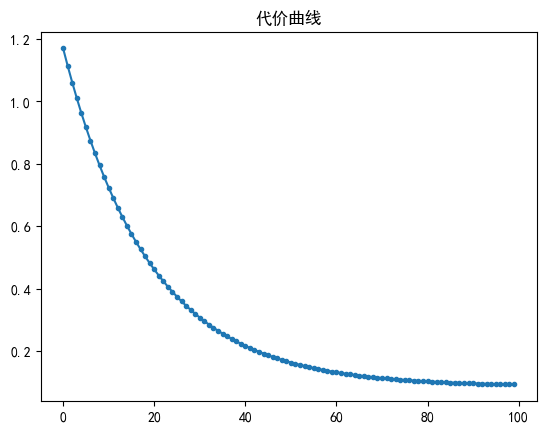

In [63]:
# 绘制代价曲线
plt.plot(jarr, marker=".")
plt.title("代价曲线")
plt.show()

### 6.输出模型参数

In [64]:
# 输出模型参数
theta

array([[0.84487687]])

### 7.绘制线性模型图

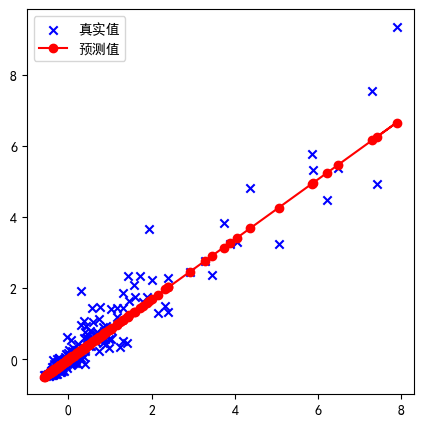

In [65]:
# 输出样本数据散点图与线性模型图
plt.figure("单变量线性回归", figsize=(5, 5))
plt.scatter(
    x_train[:, -1], y_train, c="b", marker="x", label="真实值"
)  # 画样本数据的散点图 (默认线形 ’·’,marker定义散点样式)
plt.plot(
    x_train[:, -1], h, c="r", marker="o", label="预测值"
)  # 画样本数据的散点图 (默认线形 ’·’,marker定义散点样式)
plt.legend()

## 使用pytorch进行建模,并加入偏置b

模型：

$$y = kx+b$$

#### 数据加载

In [66]:
data

,序号,电影名称,主演1,主演2,导演,想看人数,评分,发行公司,制作技术,档期,IP,首周票房,电影类型,百度搜索指数,票房
0,1,流浪地球,339,1391,1,506106,7.9,1,1,1,1,202117,科幻、剧情,81665,46.18
1,2,我和我的祖国,4261,874,9,99463,7.8,1,1,1,0,205195,剧情,375780,31.46
2,3,中国机长,150,1095,26,71001,6.7,1,1,1,1,174588,剧情、灾难,87639,28.84
3,4,疯狂的外星人,4261,1171,14,558595,6.4,1,1,1,1,145607,喜剧、科幻,41007,21.83
4,5,飞驰人生,1171,1258,0,325411,6.9,0,1,1,0,104832,喜剧,30487,17.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,198,万物生长,6291,5386,7,11830,5.7,0,1,0,1,7280,爱情、剧情,41900,1.48
198,199,破风,3288,1453,10,14931,7.3,0,1,1,0,7019,剧情,44758,1.45
199,200,王朝的女人·杨贵妃,6291,119,0,4552,3.7,1,1,1,1,9247,爱情、古装,10246,1.34
200,201,爸爸的假期,1145,7365,0,1931,4.0,1,0,1,1,5703,喜剧,21769,1.12


In [67]:
x_train = np.array([data['首周票房'].values]).reshape(-1,1)
y_train= np.array([data['票房'].values]).reshape(-1,1)

# 数据标准化处理
from sklearn.preprocessing import StandardScaler
t = StandardScaler()
x_train = t.fit_transform(x_train)

y_train = t.fit_transform(y_train)
x_train = torch.tensor(x_train,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
class Dataset(torch.utils.data.Dataset):
    def __init__(self,X_train,y_train) -> None:
        self.data = X_train
        self.label = y_train
    
    def __len__(self):              # 运算符重载
        return len(self.data)
    def __getitem__(self,i):        # 运算符重载
        return self.data[i],self.label[i]
batch_size = 12
temp_data = Dataset(x_train,y_train)
dataloader = torch.utils.data.DataLoader(dataset=temp_data, batch_size=batch_size, shuffle=True)

#### 初始化模型参数

In [68]:
w = torch.normal(0,0.01,(1,1),requires_grad=True)   # 只有一个参数
b = torch.zeros(1,requires_grad=True)               
w,b

(tensor([[0.0034]], requires_grad=True), tensor([0.], requires_grad=True))

#### 定义模型

In [69]:
def model(X,w,b):
    return torch.matmul(X,w)+b

#### 定义损失函数

In [70]:
def loss(y_hat,y):
    return (y_hat-y)**2 / 2     # 注意，在这里没有除以数据大小(批量大小),因此再下面反向传播的时候要用进行

#### 梯度下降

In [71]:
def sgd(params,lr,batch_size):
    with torch.no_grad():   # 跟新参数不求到
        for param in params:
            param -= lr * param.grad / batch_size       # 在定义损失函数的时候没有除以批量大小，在这里进行
            param.grad.zero_()      # 求导会累积梯度，每次跟新完参数要设置为0        

#### 训练模型

In [72]:
def train(lr,num_epochs,net,loss,batch_size,data):
    loss_arry = []
    for epoch in range(num_epochs):
        for X,y in data:
            l = loss(net(X,w,b),y) 
            l.sum().backward()          # 对每个分量求梯度，为什么用sum——在这之前已经除以了小批量，不需要用mean
            sgd([w,b],lr,batch_size)    # 参数跟新
        with torch.no_grad():           # 在进行求评价指标的时候也是不需要进行自动微分
            train_l = loss(net(x_train,w,b),y_train)
            loss_arry.append(float(train_l.mean()))     # loss列表
            if epoch%100==0:
                print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    return loss_arry
lr = 0.003
num_epochs = 1000
net = model
batch_size = 12
loss = loss
loss_arry = train(lr,num_epochs,net,loss,batch_size,dataloader)

epoch 1, loss 0.452986
epoch 101, loss 0.041997
epoch 201, loss 0.041982
epoch 301, loss 0.041982
epoch 401, loss 0.041982
epoch 501, loss 0.041982
epoch 601, loss 0.041982
epoch 701, loss 0.041982
epoch 801, loss 0.041982
epoch 901, loss 0.041982


#### 模型评估

In [73]:
h = model(x_train,w,b)
print("线性回归精度R^2：", R2(h.detach().numpy(), y_train.detach().numpy()))
print("线性回归精度MSE：", MSE(h.detach().numpy(), y_train.detach().numpy()))

线性回归精度R^2： 0.916036881506443
线性回归精度MSE： 0.0839631203377601


#### 绘制损失函数

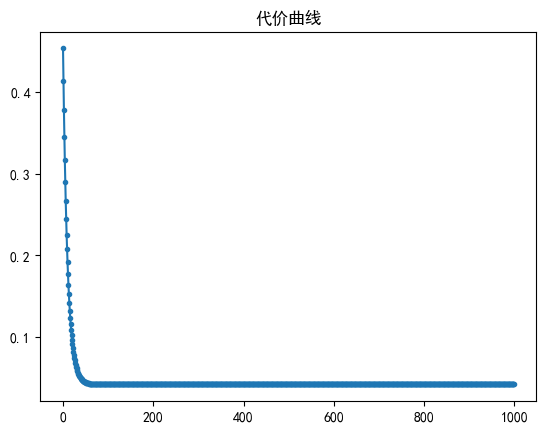

In [74]:
plt.plot(loss_arry, marker=".")
plt.title("代价曲线")
plt.show()

#### 查看模型参数

In [75]:
w,b

(tensor([[0.9571]], requires_grad=True),
 tensor([5.5969e-05], requires_grad=True))

#### 绘制样本模型图

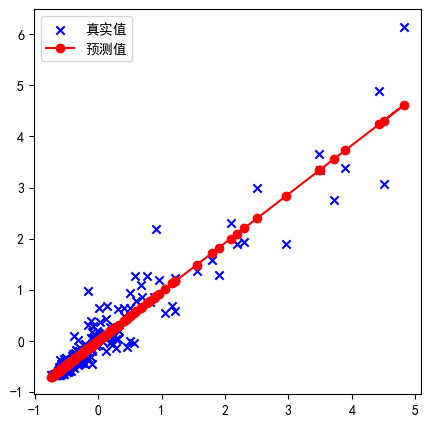

In [76]:
plt.figure("单变量线性回归", figsize=(5, 5))
plt.scatter(
    x_train[:, -1], y_train, c="b", marker="x", label="真实值"
)  # 画样本数据的散点图 (默认线形 ’·’,marker定义散点样式)
plt.plot(
    x_train[:, -1], h.detach().numpy(), c="r", marker="o", label="预测值"
)  # 画样本数据的散点图 (默认线形 ’·’,marker定义散点样式)
plt.legend()

## 多元线性回归

In [77]:
data

,序号,电影名称,主演1,主演2,导演,想看人数,评分,发行公司,制作技术,档期,IP,首周票房,电影类型,百度搜索指数,票房
0,1,流浪地球,339,1391,1,506106,7.9,1,1,1,1,202117,科幻、剧情,81665,46.18
1,2,我和我的祖国,4261,874,9,99463,7.8,1,1,1,0,205195,剧情,375780,31.46
2,3,中国机长,150,1095,26,71001,6.7,1,1,1,1,174588,剧情、灾难,87639,28.84
3,4,疯狂的外星人,4261,1171,14,558595,6.4,1,1,1,1,145607,喜剧、科幻,41007,21.83
4,5,飞驰人生,1171,1258,0,325411,6.9,0,1,1,0,104832,喜剧,30487,17.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,198,万物生长,6291,5386,7,11830,5.7,0,1,0,1,7280,爱情、剧情,41900,1.48
198,199,破风,3288,1453,10,14931,7.3,0,1,1,0,7019,剧情,44758,1.45
199,200,王朝的女人·杨贵妃,6291,119,0,4552,3.7,1,1,1,1,9247,爱情、古装,10246,1.34
200,201,爸爸的假期,1145,7365,0,1931,4.0,1,0,1,1,5703,喜剧,21769,1.12


### 数据预处理

In [78]:
# 电影类型进行标签映射
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
data_ = data[data.columns]

label_encoder = LabelEncoder()
data_['电影类型'] = label_encoder.fit_transform(data_['电影类型'])

standard_columns = ['主演1','主演2','导演','想看人数','评分','首周票房','电影类型','百度搜索指数','票房']
rob = RobustScaler()            # 四分卫放缩，解决异常值
data_[standard_columns] = rob.fit_transform(data_[standard_columns])
data_


,序号,电影名称,主演1,主演2,导演,想看人数,评分,发行公司,制作技术,档期,IP,首周票房,电影类型,百度搜索指数,票房
0,1,流浪地球,-0.468393,-0.034093,-0.166667,15.789815,1.047619,1,1,1,1,7.289828,1.468354,1.415138,7.548273
1,2,我和我的祖国,0.446466,-0.190074,1.166667,2.584655,1.000000,1,1,1,0,7.411674,-1.063291,9.011868,4.940655
2,3,中国机长,-0.512480,-0.123397,4.000000,1.660391,0.476190,1,1,1,1,6.200067,-0.607595,1.569442,4.476528
3,4,疯狂的外星人,0.446466,-0.100468,2.000000,17.494321,0.333333,1,1,1,1,5.052827,0.405063,0.364978,3.234721
4,5,飞驰人生,-0.274318,-0.074219,-0.333333,9.921998,0.571429,0,1,1,0,3.438711,0.000000,0.093256,2.384411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,198,万物生长,0.919991,1.171217,0.833333,-0.261104,0.000000,0,1,0,1,-0.422976,1.063291,0.388044,-0.370239
198,199,破风,0.219501,-0.015387,1.333333,-0.160403,0.761905,0,1,1,0,-0.433308,-1.063291,0.461863,-0.375554
199,200,王朝的女人·杨贵妃,0.919991,-0.417861,-0.333333,-0.497447,-0.952381,1,1,1,1,-0.345110,1.113924,-0.429551,-0.395040
200,201,爸爸的假期,-0.280383,1.768291,-0.333333,-0.582560,-0.809524,1,0,1,1,-0.485403,0.000000,-0.131922,-0.434012


In [79]:
b = np.zeros((len(data_),1))        # 添加一个偏置
x_train = data_[[i for i in data.columns if i not in ['序号',"电影名称","票房"]]].values
x_train = np.hstack((b,x_train))
y_train = data['票房'].values.reshape(-1,1)

### 2.确定模型、损失函数、梯度下降


In [80]:
# 模型
def model(x, W):
    h = x.dot(W)  # 预估值h
    return h


# 代价函数
def cost(h, y):
    m = len(h)  # 计算样本数
    e = y - h  # 误差
    J = 1.0 / (2 * m) * np.sum(e.T.dot(e))  # 计算代价
    return J


# 梯度下降求最优解
# lr =0.01 学习率
# count_iter 迭代次数
def gradDesc(x, y, lr=0.1, count_iter=1000):
    m, n = x.shape  # sharp返回值是元组（行，列）并赋值给m,n
    W = np.zeros((n, 1))  # 定义W初始值,W为矩阵（从初始值开始，沿着初始值下降）
    jarr = np.zeros(
        count_iter
    )  # 代价数组(多维数组<class 'numpy.ndarray'>)[0. 0. 0. ... 0. 0. 0.]
    # 对W进行更新
    for i in range(count_iter):
        h = model(x, W)  # 计算预估值
        jarr[i] = cost(h, y)  # 计算代价并存入数组
        e = y - h  # 计算误差
        deltaW = (1.0 / m) * x.T.dot(e)  # 计算deltaW（梯度下降）
        # print(i,deltaW)
        W += lr * deltaW  # 更新deltaW（迭代）

    return jarr, W

### 输出模型参数、预测值、损失函数、代价曲线、模型评估、线性建模

W 为： [[ 0.        ]
 [-0.19243402]
 [ 0.31778639]
 [-0.0187928 ]
 [ 0.01834062]
 [ 1.73625252]
 [ 1.3758788 ]
 [ 0.93084587]
 [ 1.58033508]
 [ 1.74311719]
 [ 4.71379736]
 [ 0.39073964]
 [-0.02388806]]
线性回归精度R^2： 0.8954267223570447
线性回归精度MSE： 6.871616686175255


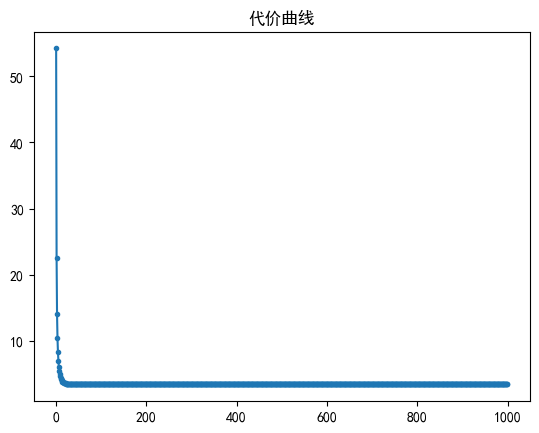

In [81]:
# 调用梯度下降得到最优模型
jarr, W = gradDesc(x_train, y_train)

# 预估值
h = model(x_train, W)

# 输出模型
print("W 为：", W)
print("线性回归精度R^2：", R2(h, y_train))
print("线性回归精度MSE：", MSE(y_train,h ))


# 画代价曲线
plt.plot(jarr, marker=".")
plt.title("代价曲线")
plt.show()

### 输出线性模型图

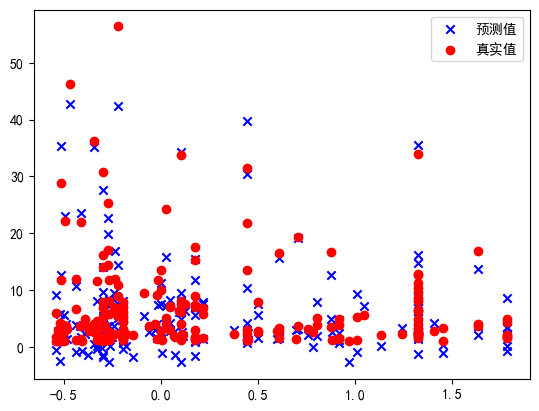

In [82]:
plt.scatter(x_train[:, 1], h, c="b", marker="x", label="预测值")
plt.scatter(x_train[:, 1], y_train, c="r", marker="o", label="真实值")
plt.legend()
plt.show()

## Pytorch对多元线性回归进行建模

In [83]:
data

,序号,电影名称,主演1,主演2,导演,想看人数,评分,发行公司,制作技术,档期,IP,首周票房,电影类型,百度搜索指数,票房
0,1,流浪地球,339,1391,1,506106,7.9,1,1,1,1,202117,科幻、剧情,81665,46.18
1,2,我和我的祖国,4261,874,9,99463,7.8,1,1,1,0,205195,剧情,375780,31.46
2,3,中国机长,150,1095,26,71001,6.7,1,1,1,1,174588,剧情、灾难,87639,28.84
3,4,疯狂的外星人,4261,1171,14,558595,6.4,1,1,1,1,145607,喜剧、科幻,41007,21.83
4,5,飞驰人生,1171,1258,0,325411,6.9,0,1,1,0,104832,喜剧,30487,17.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,198,万物生长,6291,5386,7,11830,5.7,0,1,0,1,7280,爱情、剧情,41900,1.48
198,199,破风,3288,1453,10,14931,7.3,0,1,1,0,7019,剧情,44758,1.45
199,200,王朝的女人·杨贵妃,6291,119,0,4552,3.7,1,1,1,1,9247,爱情、古装,10246,1.34
200,201,爸爸的假期,1145,7365,0,1931,4.0,1,0,1,1,5703,喜剧,21769,1.12


In [84]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
data_ = data[data.columns]
label_encoder = LabelEncoder()
data_['电影类型'] = label_encoder.fit_transform(data_['电影类型'])

standard_columns = ['主演1','主演2','导演','想看人数','评分','首周票房','电影类型','百度搜索指数','票房']
standard = StandardScaler()
data_[standard_columns] = standard.fit_transform(data_[standard_columns])
x_train = data_[[i for i in data.columns if i not in ['序号',"电影名称","票房"]]].values
y_train = data['票房'].values.reshape(-1,1)
x_train,y_train
# 数据标准化处理
from sklearn.preprocessing import StandardScaler
t = StandardScaler()
x_train = t.fit_transform(x_train)

y_train = t.fit_transform(y_train)
x_train = torch.tensor(x_train,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
class Dataset(torch.utils.data.Dataset):
    def __init__(self,X_train,y_train) -> None:
        self.data = x_train
        self.label = y_train
    
    def __len__(self):              # 运算符重载
        return len(self.data)
    def __getitem__(self,i):        # 运算符重载
        return self.data[i],self.label[i]
batch_size = 16
temp_data = Dataset(x_train,y_train)
dataloader = torch.utils.data.DataLoader(dataset=temp_data, batch_size=batch_size, shuffle=True)


### 初始化模型参数

In [85]:
w = torch.normal(0,0.01,(12,1),requires_grad=True)      # 正态分布初始化
b = torch.zeros(1,requires_grad=True)
w,b

(tensor([[ 0.0013],
         [ 0.0038],
         [ 0.0002],
         [ 0.0072],
         [-0.0022],
         [ 0.0142],
         [ 0.0064],
         [ 0.0086],
         [-0.0092],
         [ 0.0047],
         [-0.0073],
         [-0.0046]], requires_grad=True),
 tensor([0.], requires_grad=True))

### 建立模型

In [86]:
def model(X,w,b):
    return torch.matmul(X,w)+b


def loss(y_hat,y):
    return (y_hat-y)**2 / 2     # 注意，在这里没有除以数据大小(批量大小),因此再下面反向传播的时候要用进行


def sgd(params,lr,batch_size):
    with torch.no_grad():   # 跟新参数不求到
        for param in params:
            param -= lr * param.grad / batch_size       # 在定义损失函数的时候没有除以批量大小，在这里进行
            param.grad.zero_()      # 求导会累积梯度，每次跟新完参数要设置为0        

def train(lr,num_epochs,net,loss,batch_size,data):
    loss_arry = []
    for epoch in range(num_epochs):
        for X,y in data:
            l = loss(net(X,w,b),y) 
            l.sum().backward()          # 对每个分量求梯度，为什么用sum——在这之前已经除以了小批量，不需要用mean
            sgd([w,b],lr,batch_size)    # 参数跟新
        with torch.no_grad():           # 在进行求评价指标的时候也是不需要进行自动微分
            train_l = loss(net(x_train,w,b),y_train)
            loss_arry.append(float(train_l.mean()))     # loss列表
            if epoch %100==0:
                print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    return loss_arry
lr = 0.003
num_epochs = 1000
net = model
batch_size = 32
loss = loss
loss_arry = train(lr,num_epochs,net,loss,batch_size,dataloader)

epoch 1, loss 0.463623
epoch 101, loss 0.058362
epoch 201, loss 0.040903
epoch 301, loss 0.037196
epoch 401, loss 0.036356
epoch 501, loss 0.036161
epoch 601, loss 0.036115
epoch 701, loss 0.036104
epoch 801, loss 0.036101
epoch 901, loss 0.036101


### 模型评估

In [87]:
h = model(x_train,w,b)
print("线性回归精度R^2：", R2(h.detach().numpy(), y_train.detach().numpy()))
print("线性回归精度MSE：", MSE(h.detach().numpy(), y_train.detach().numpy()))

线性回归精度R^2： 0.9277988821268082
线性回归精度MSE： 0.0722011150700031


### 绘制代价函数

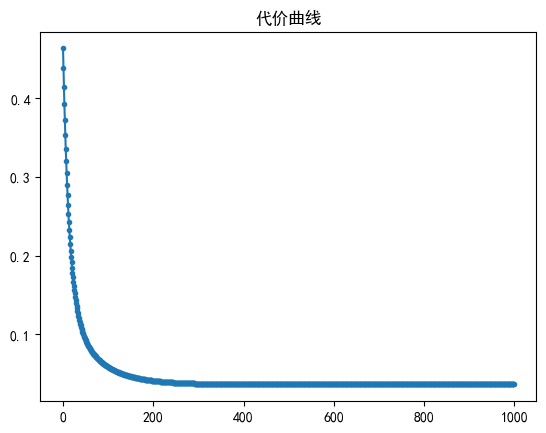

In [88]:
plt.plot(loss_arry, marker=".")
plt.title("代价曲线")
plt.show()

### 查看参数

In [89]:
w,b

(tensor([[-0.0261],
         [ 0.0057],
         [-0.0289],
         [-0.0099],
         [ 0.1110],
         [ 0.0132],
         [ 0.0075],
         [ 0.0022],
         [ 0.0085],
         [ 0.9305],
         [ 0.0285],
         [-0.0075]], requires_grad=True),
 tensor([-4.1108e-06], requires_grad=True))

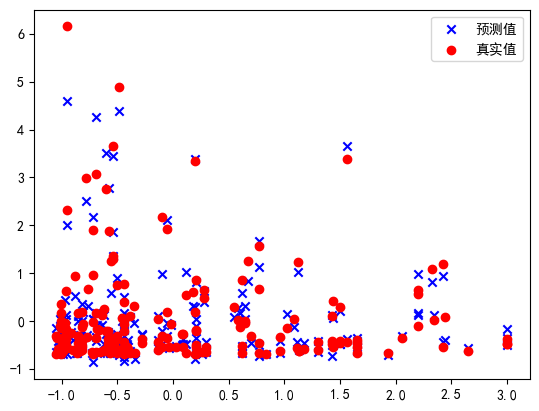

In [90]:
plt.scatter(x_train[:, 1], h.detach().numpy(), c="b", marker="x", label="预测值")
plt.scatter(x_train[:, 1], y_train, c="r", marker="o", label="真实值")
plt.legend()
plt.show()